<a href="https://colab.research.google.com/github/ibonetc/DeepLearning_Salud/blob/main/UNET_RetinaExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problema de segmentación en Retina

Las estructuras exhibidas por la vasculatura retiniana infieren información crítica sobre una amplia gama de patologías retinianas como la prematuridad (RoP), la retinopatía diabética (DR), el glaucoma, la hipertensión y la degeneración macular relacionada con la edad (AMD). Estas patologías se encuentran entre las principales causas de ceguera. La segmentación precisa de la vasculatura retiniana es importante para varios procedimientos diagnósticos y terapéuticos oftalmológicos.

Vamos a usar una base de datos DRIVE(Digital Retinal Images for Vessel Extraction) que puede ver en: https://drive.grand-challenge.org/.

La base de datos DRIVE se desarrolló con la idea de permitir estudios comparativos sobre la segmentación de los vasos sanguíneos en las imágenes de la retina. 

La segmentación de los vasos de la retina y la delimitación de los atributos morfológicos de los vasos sanguíneos de la retina, como la longitud, la anchura, la tortuosidad, los patrones de ramificación y los ángulos, se utilizan para el diagnóstico, la detección, el tratamiento y la evaluación de diversas enfermedades cardiovasculares y oftalmológicas, como la diabetes, la hipertensión y la arteriosclerosis. y neovascularización coroidea. 

La detección automática y el análisis de la vasculatura pueden ayudar en la implementación de programas de detección para la retinopatía diabética, pueden ayudar a la investigación sobre la relación entre la tortuosidad de los vasos y la retinopatía hipertensiva, la medición del diámetro de los vasos en relación con el diagnóstico de hipertensión y la cirugía láser asistida por computadora. 

La generación automática de mapas retinianos y la extracción de puntos de ramificación se han utilizado para el registro de imágenes temporales o multimodales y la síntesis de mosaicos de imágenes retinianas. Además, el árbol vascular de la retina es único para cada individuo y puede usarse para la identificación biométrica.

## Carga de datos

Las imágenes originales de DRIVE tienen un tamaño de 565 × 584. Se redimensionaron a 512 × 512

Para preparar nuestros datos para el entrenamiento, primero debemos reescalarlos dentro del intervalo [0, 1], para lo que vamos a dividir las imágenes por 255. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from tensorflow.keras.utils import plot_model

In [ ]:
!unzip '/content/drive/MyDrive/HealthData/DriveJPG.zip'

In [ ]:
pathImages='/content/DriveJPG/train/image'
pathMask='/content/DriveJPG/train/mask'

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

## Métricas

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Entrenar el modelo

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

### Hiperparámetros

In [ ]:
""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

### Dirección de la base de datos

In [ ]:
""" Dataset """
dataset_path = "/content/DriveJPG"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

In [ ]:
train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)
train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

### Modelo UNET

In [ ]:
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
model.summary()

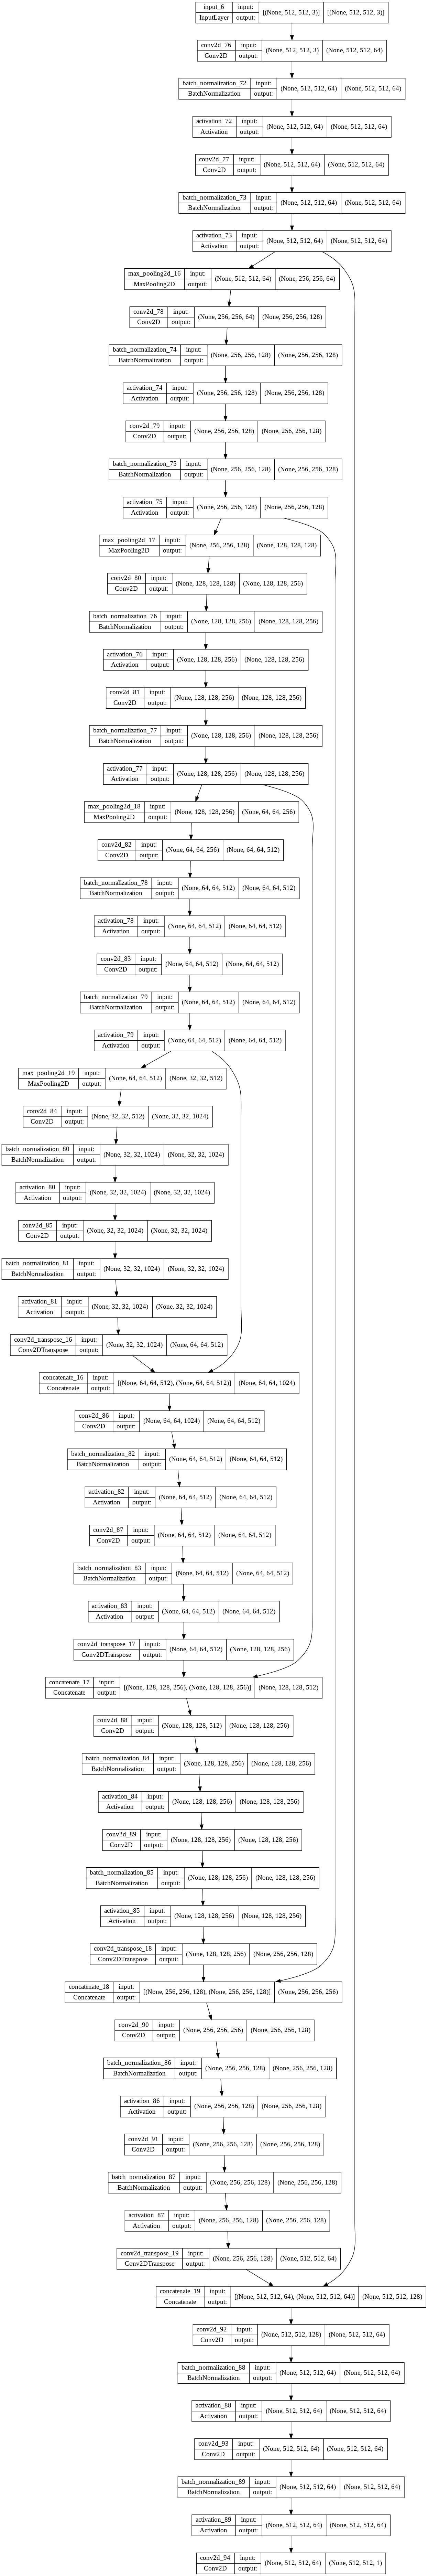

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    #ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    #CSVLogger(csv_path),
    #TensorBoard(),
    #EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image_r(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask_r(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

### Cargar el modelo entrenado y crear carpeta para resultados.

In [ ]:
create_dir("results")

""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("files/model.h5")

## Hacer predicción

### Cargar los datos de prueba

In [ ]:
dataset_path = '/content/DriveJPG/test'
test_x, test_y = load_data(dataset_path)

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
SCORE = []
images_predicted=[]
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image_r(x)
    ori_y, y = read_mask_r(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_image_path_predicted = f"results/{name}_predicted.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)
    images_predicted.append(y_pred.copy())
    """ Saving predicted images """
    y_pred_save= y_pred.copy()
    y_pred_save = np.expand_dims(y_pred_save, axis=-1)*255
    cv2.imwrite(save_image_path_predicted, y_pred_save)
    

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])



100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


In [ ]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

Accuracy: 0.95222
F1: 0.53392
Jaccard: 0.36499
Recall: 0.81788
Precision: 0.40524


## Comparar las diferencias

Vamos a dibujar en rojo lo que tiene de más con respecto a la original y en azul lo que le falta todavía por tener

In [ ]:
from PIL import Image

In [ ]:
image_idx = "01"

In [ ]:
gt_path='/content/DriveJPG/test/mask/'+image_idx+'_test.jpg'
predicted_path='/content/results/'+image_idx+'_test_predicted.png'

In [ ]:
gt = np.array(Image.open(gt_path))
predicted = np.array(Image.open(predicted_path))

In [ ]:
diff = np.zeros(gt.shape+(3,))
print(diff.shape, gt.shape)
diff[:, :, 0] = gt
diff[:, :, 1] = gt
diff[:, :, 2] = predicted
path_diff='/content/results/'+image_idx+'_diff.jpg'
cv2.imwrite(path_diff , diff)

(512, 512, 3) (512, 512)


True

In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

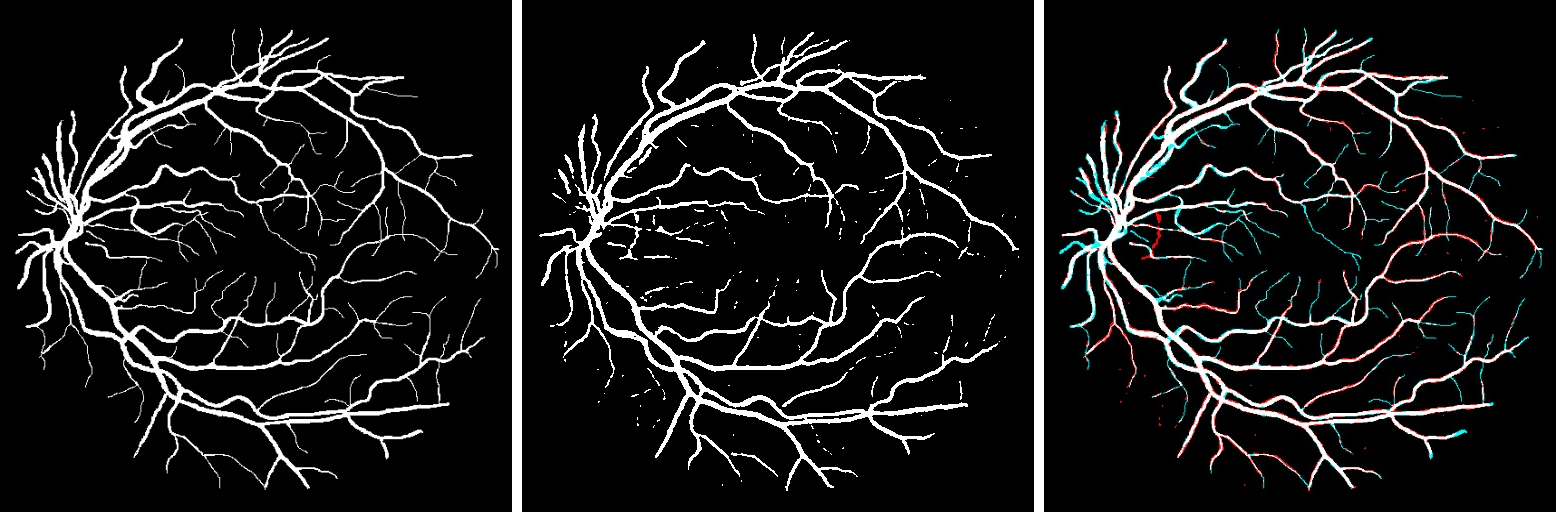

In [ ]:
x1 = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
x2 = cv2.imread(predicted_path, cv2.IMREAD_GRAYSCALE)
x3 = cv2.imread(path_diff, cv2.IMREAD_COLOR)
line = np.ones((H, 10, 3)) * 255

x1 = np.expand_dims(x1, axis=-1)
x1 = np.concatenate([x1, x1, x1], axis=-1)

x2 = np.expand_dims(x2, axis=-1)
x2 = np.concatenate([x2, x2, x2], axis=-1)

cat_images = np.concatenate([x1, line, x2, line, x3], axis=1)
#cv2.imwrite('comparation.jpg', cat_images)
cv2_imshow(cat_images)